In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [4]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/BCC 4773
data/train/VASC 3488
data/train/AKIEC 3856
data/train/NV 4975


In [6]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation\AKIEC 1552
data/validation\BCC 1692
data/validation\BKL 1479
data/validation\DF 1632
data/validation\MEL 1664
data/validation\NV 1730
data/validation\VASC 1484


In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [8]:
## Intilizing variables
output_classes = 7

epochs = 50
droput_rate= 0.5
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))
model.add(Dropout(rate=droput_rate))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2048/2048 [==============================] - 1247s 609ms/step - loss: 0.8035 - acc: 0.7252 - val_loss: 0.4866 - val_acc: 0.8336
Epoch 2/50
2048/2048 [==============================] - 1226s 599ms/step - loss: 0.1786 - acc: 0.9446 - val_loss: 0.3417 - val_acc: 0.8766
Epoch 3/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0551 - acc: 0.9854 - val_loss: 0.3219 - val_acc: 0.8852
Epoch 4/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0193 - acc: 0.9959 - val_loss: 0.3270 - val_acc: 0.8854
Epoch 5/50
2048/2048 [==============================] - 1226s 598ms/step - loss: 0.0095 - acc: 0.9982 - val_loss: 0.3290 - val_acc: 0.8895
Epoch 6/50
2048/2048 [==============================] - 1225s 598ms/step - loss: 0.0062 - acc: 0.9987 - val_loss: 0.3657 - val_acc: 0.8895
Epoch 7/50
2048/2048 [==============================] - 1228s 600ms/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.3651 - val_acc: 0.8914
Epoch 8/50
2048/2048 [================

In [10]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.4533282817527652
Test Accuracy:  0.9025


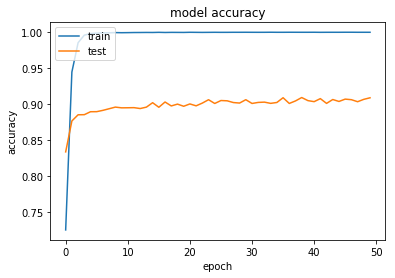

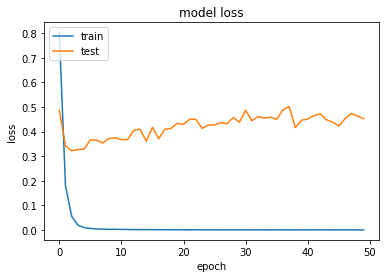

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [14]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [15]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [20]:
from keras.models import load_model
model = load_model("models/2.Xception2-Adam-without-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model.load_weights("models/2.Xception2-Adam-without-Dropout-Weights.h5")


In [21]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 3306s 9s/step
No of errors = 1139/11233


Confusion matrix
[[1413   41   43    0   36   19    0]
 [  16 1624   18    0   14   20    0]
 [   5    4 1377    0   46   47    0]
 [  21   90   56 1444    0   20    1]
 [   6   14   29    1 1448  166    0]
 [   3   14   29    1   35 1647    1]
 [   2    2  263    4   41   31 1141]]


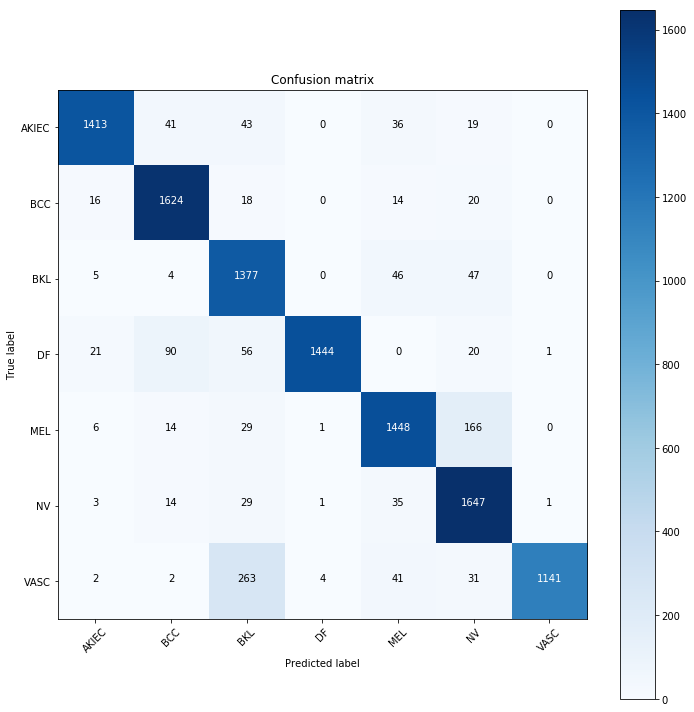

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [24]:
predict_and_report(train_generator, model)

Accuracy: 0.3100945125238078
Area Under the Receiver Operating Characteristic Curve: 0.1672594777478963
             precision    recall  f1-score   support

          0       1.00      0.17      0.29     23054
          1       1.00      1.00      1.00      4773
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0

avg / total       1.00      0.31      0.41     27827



In [25]:
predict_and_report(validation_generator, model)

Accuracy: 0.27365797204664827
Area Under the Receiver Operating Characteristic Curve: 0.17181001590002384
             precision    recall  f1-score   support

          0       0.99      0.15      0.26      9541
          1       0.91      0.96      0.93      1692
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0

avg / total       0.98      0.27      0.36     11233



In [18]:
model.save('models/2.Xception-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception-Adam-without-Dropout-Weights.h5')

In [19]:
##########################################################################################################

# Misclassified Images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class], pred_class)
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
plt.show()

___

In [10]:
from keras.applications import DenseNet201
model = Xception(weights = xception_weights, include_top=False, pooling = 'avg', input_shape = (225, 300, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model = Model(input = model.input, output = predictions)

model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])

In [11]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 1279s 625ms/step - loss: 1.7460 - categorical_accuracy: 0.5352 - fmeasure: 0.5237 - recall: 0.4758 - precision: 0.5877 - val_loss: 1.0665 - val_categorical_accuracy: 0.7224 - val_fmeasure: 0.7221 - val_recall: 0.6707 - val_precision: 0.7840
Epoch 2/50
2048/2048 [==============================] - 1309s 639ms/step - loss: 0.8476 - categorical_accuracy: 0.8002 - fmeasure: 0.8013 - recall: 0.7741 - precision: 0.8316 - val_loss: 0.8152 - val_categorical_accuracy: 0.8099 - val_fmeasure: 0.8131 - val_recall: 0.7852 - val_precision: 0.8442
Epoch 3/50
2048/2048 [==============================] - 1312s 641ms/step - loss: 0.5418 - categorical_accuracy: 0.8953 - fmeasure: 0.8960 - recall: 0.8834 - precision: 0.9094 - val_loss: 0.7169 - val_categorical_accuracy: 0.8475 - val_fmeasure: 0.8547 - val_recall: 0.8370 - val_precision: 0.8739
Epoch 4/50
2048/2048 [==============================] - 1312s 641ms/step - loss: 0.3932 - categorical_accurac

In [12]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.6869810661673545
Test Accuracy:  0.90125
fmeasure:  0.9017162108421326
Recall:  0.900625
Precision:  0.9028427410125732


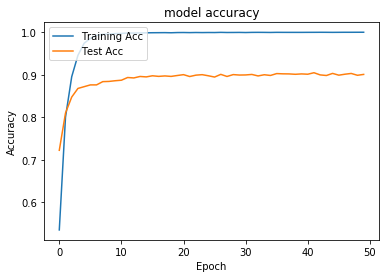

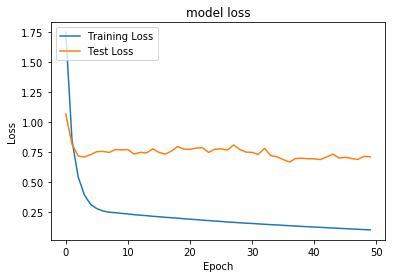

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [32]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [20]:
model.save('models/2.Xception2-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception2-Adam-without-Dropout-Weights.h5')